In [1]:
# Cell 1: Setup and Imports

import re
import os
import json
import torch
import warnings
import numpy as np
import pandas as pd
from umap import UMAP
import torch.nn as nn
from tqdm import tqdm
from tqdm.auto import tqdm 
from fuzzywuzzy import process
from haversine import haversine
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.stats import entropy
warnings.filterwarnings('ignore')
from itertools import permutations
from itertools import combinations
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from geopy.geocoders import Nominatim
from torch_geometric.nn import GCNConv
from sklearn.model_selection import KFold
from torch_geometric.data import HeteroData
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from geopy.extra.rate_limiter import RateLimiter
from sklearn.metrics.pairwise import haversine_distances
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configuration
DATA_PATH = "Incidents_imputed.xlsx" 
SUBSTATION_PATH = "Substation_Cleaned.csv"  
LINES_PATH = "Lines_Cleaned.csv"           
MAX_WORKERS = 4

In [2]:
# Cell 2: Data Loader with Chunking
def clean_and_standardize_substations(substation_name):
    """Cleans substation names to a standardized '<feeder_id>:<substation_name>' format."""
    match = re.match(r"(\d+)\s*:\s*(.+)", substation_name.strip().upper())
    if match:
        feeder_id, name = match.groups()
        return f"{feeder_id}:{name.strip()}"
    else:
        return None  # Mark invalid format clearly


def load_data():
    # Load incident data
    incident_df = pd.read_excel(
        DATA_PATH,
        parse_dates=['Job OFF Time', 'Job ON Time'],
        engine='openpyxl'
    )

# Clean and standardize Job Substation names explicitly
    incident_df['Job Substation'] = incident_df['Job Substation'].apply(clean_and_standardize_substations)
    dropped_count = incident_df['Job Substation'].isna().sum()
    incident_df.dropna(subset=['Job Substation'], inplace=True)

    # Load and clean substation data
    substation_df = pd.read_csv(SUBSTATION_PATH)
    substation_df['Name'] = substation_df['Name'].str.strip().str.upper()

    # Load lines data clearly
    lines_df = pd.read_csv(LINES_PATH)

    print(f"Dropped {dropped_count} invalid substations due to format issues.")

    
    return incident_df, substation_df, lines_df

# Load all datasets
incident_df, substation_df, lines_df = load_data()
print(f"Loaded {len(incident_df)} incident records, {len(substation_df)} substations, {len(lines_df)} lines")

Dropped 2 invalid substations due to format issues.
Loaded 292827 incident records, 709 substations, 1040 lines


In [3]:
# Extract and print sorted unique names explicitly
unique_substations_incident = incident_df['Job Substation'].sort_values().unique()

print("Unique Substations from Incident Data (after stripping and uppercase):\n")
for name in unique_substations_incident:
    print(name)

Unique Substations from Incident Data (after stripping and uppercase):

3109:HONOR HEIGHTS
3110:RIVERSIDE
3111:FIVE TRIBES
3114:TENNYSON
3116:CALLERY
3117:THREE RIVERS
3128:HANCOCK
3131:MUSKOGEE WW
3132:MUSKOGEE PORT
3136:EUCLID
3137:AGENCY
3205:SAPULPA
3207:HILL TOP
3208:TIBBENS ROAD
3209:BIXBY
3210:HICKORY HILL
3213:BOWDEN
3214:LONE STAR
3216:BEELINE
3217:POLECAT CREEK
3218:BEGGS
3220:KELLYVILLE
3312:CHECOTAH
3313:ILLINOIS RIVER
3314:PORUM
3315:WARNER TAP
3316:WARNER
3321:ROSS LAKE
3325:WELLS
3326:JAMESVILLE
3327:VIAN
3329:KEETOOWAH
3332:EUFAULA SPA
3335:KERR MCGEE SEQ
3505:POTEAU
3506:CAVANAL MTN
3507:HOWE
3508:SPIRO COAL
3509:PANAMA
3514:HEAVENER
3516:TARBY
3607:ROLAND ROAD
3608:MULDROW
3907:YAFFE
4104:GRANARY
4105:ENID
4106:HEMLOCK
4107:CLEVELAND AVE
4109:WAUKOMIS
4112:CHESTNUT
4119:GLENWOOD
4123:KREMLIN TAP
4135:SO 4TH ST
4151:VANCE AFB
4153:IMO
4155:ENID INDUSTRIA
4157:NE ENID
4158:FAIRMONT
4159:PLAINSMEN
4210:MEDFORD
4211:GRANT COUNTY
4215:CONT EMPIRE
4215:CONTINENTAL EMPIRE
42

In [8]:
def calculate_centroids_and_feeders(incident_df, substation_df, threshold=70):
    """
    Processes incident and substation data to compute centroids, feeder information, 
    and cities associated with each substation. Ensures Voltage is retained.
    """

    # Validate coordinate ranges using the correct columns
    assert (substation_df['X'].between(-180, 180).all()), "Invalid longitude in substation data"
    assert (substation_df['Y'].between(-90, 90).all()), "Invalid latitude in substation data"

    # Ensure X and Y are stored as full-precision float64
    substation_df['X'] = substation_df['X'].astype(float)
    substation_df['Y'] = substation_df['Y'].astype(float)

    # Clean and format names
    incident_df['Job Substation'] = incident_df['Job Substation'].str.strip().str.upper()
    substation_df['Name'] = substation_df['Name'].str.strip().str.upper()

    # Improved colon handling: swap parts if separated by ":" but ensure it doesn't fail
    incident_df['Formatted Job Substation'] = incident_df['Job Substation'].apply(
        lambda x: f"{x.split(':')[1].strip()} {x.split(':')[0].strip()}" 
        if ":" in x and len(x.split(':')) == 2 else x
    )

    # Fuzzy matching
    substation_names = substation_df['Name'].tolist()
    fuzzy_matches = {}
    for incident_name in incident_df['Formatted Job Substation'].unique():
        best_match, score = process.extractOne(incident_name, substation_names)
        fuzzy_matches[incident_name] = best_match if score >= threshold else None

    # Map fuzzy matches back to the incident DataFrame
    incident_df['Matched Substation'] = incident_df['Formatted Job Substation'].map(fuzzy_matches)

    # Flag unmatched substations for later analysis
    incident_df['Unmatched_Flag'] = incident_df['Matched Substation'].isna()

    # Get unique matched substations from incidents
    matched_subs = set(incident_df['Matched Substation'].dropna().unique())
    valid_substations = substation_df[substation_df['Name'].isin(matched_subs)]

    # Aggregate feeder information
    feeder_agg = (
        incident_df[~incident_df['Unmatched_Flag']]
        .groupby('Matched Substation')['Feeder ID']
        .agg(lambda x: list(set(x)) if not x.empty else [])
        .reset_index(name='feeders')
    )

    # Aggregate city information using the imputed values
    city_agg = (
        incident_df[~incident_df['Unmatched_Flag']]
        .groupby('Matched Substation')['Job City_imputed']
        .agg(lambda x: list(set(x)) if not x.empty else [])
        .reset_index(name='cities')
    )

    # Merge substation coordinates with feeder and city information
    centroids = valid_substations.rename(columns={'Name': 'Matched Substation'})
    centroids = centroids[['Matched Substation', 'X', 'Y', 'Voltage']]
    centroids = centroids.merge(feeder_agg, on='Matched Substation', how='left')
    centroids = centroids.merge(city_agg, on='Matched Substation', how='left')

    # Restore original Job Substation format
    incident_mapping = incident_df[['Matched Substation', 'Job Substation']].drop_duplicates()
    centroids = centroids.merge(incident_mapping, on='Matched Substation', how='left')
    centroids['Job Substation'] = centroids['Job Substation'].fillna(centroids['Matched Substation'])
    centroids.drop(columns=['Matched Substation'], inplace=True)

    # Ensure X and Y retain full precision (up to 12 decimal places)
    centroids['X'] = centroids['X'].map(lambda x: float(f"{x:.12f}"))
    centroids['Y'] = centroids['Y'].map(lambda x: float(f"{x:.12f}"))


    # Rename columns for clarity: X as centroid_lon, Y as centroid_lat
    centroids = centroids.rename(columns={
        'X': 'centroid_lon',
        'Y': 'centroid_lat'
    })

    # -------- New addition (metadata integration) --------
    metadata_cols = ['Name', 'PLANTCLASS']
    centroids = centroids.merge(
        substation_df[metadata_cols].rename(columns={'Name': 'Job Substation'}),
        on='Job Substation',
        how='left'
    )

    # Explicitly handle missing categorical metadata
    centroids[['PLANTCLASS']] = centroids[['PLANTCLASS']].fillna('Unknown')
    
    # Separate unmatched substations for further review
    unmatched_substations = incident_df[incident_df['Unmatched_Flag']][['Job Substation']].drop_duplicates()
    print(f"Info: {len(unmatched_substations)} substations did not match and are flagged for review.")

    # Debugging check: Print some values to verify precision
    print(centroids[['centroid_lon', 'centroid_lat']].applymap(lambda x: f"{x:.12f}"))

    return centroids, unmatched_substations

# Usage example:
centroids, unmatched = calculate_centroids_and_feeders(incident_df, substation_df)
print(f"Final centroids: {len(centroids)} substations (only those with incidents and coordinates)")
print(f"Unmatched substations: {len(unmatched)} (flagged for further review)")


Info: 15 substations did not match and are flagged for review.
         centroid_lon     centroid_lat
0    -96.825849590000  34.989951630000
1    -96.739096680000  34.956678930000
2    -96.534032990000  34.941371780000
3    -96.931588840000  35.065887700000
4    -96.494698980000  35.087530450000
..                ...              ...
342  -96.841748000000  34.957498000000
343  -97.404172800000  35.402245110000
344  -97.754543220000  36.380719570000
345  -96.652016390000  34.752418670000
346  -96.347185660000  33.983333070000

[347 rows x 2 columns]
Final centroids: 347 substations (only those with incidents and coordinates)
Unmatched substations: 15 (flagged for further review)


In [9]:
# Cell 4 : Proximity Threshold Calculation + Line Matching

def calculate_proximity_threshold(incident_df, centroids):
    """Calculate median distance between substations co-affected by weather events with validation.
    """

    # Step 1: Dynamically extract all weather-related causes
    weather_terms = [
        'WEATHER', 'STORM', 'LIGHTNING', 'WILDFIRE', 'RAIN', 'WIND', 'SNOW', 
        'FOG', 'EXTREME COLD', 'EXTREME HEAT', 'ICE', 'SLEET', 'HIGH WINDS'
    ]
    
    # Extract all unique cause descriptions that contain any weather-related term
    weather_causes_list = [
        cause for cause in incident_df['Cause Desc'].dropna().unique() 
        if any(term in cause.upper() for term in weather_terms)
    ]
    
    print(f"Identified {len(weather_causes_list)} weather-related causes:\n{weather_causes_list}\n")

    # Step 2: Filter weather-related incidents
    weather_mask = incident_df['Cause Desc'].isin(weather_causes_list)
    weather_subs = incident_df[weather_mask]['Job Substation'].unique()

    # Step 3: Check for missing substations in centroids
    sub_coords = centroids.set_index('Job Substation')[['centroid_lat', 'centroid_lon']].to_dict('index')
    missing_subs = [sub for sub in weather_subs if sub not in sub_coords]

    if missing_subs:
        print(f"⚠️ Warning: {len(missing_subs)} substations affected by weather incidents do not have coordinates in centroids.")
        print(f"Missing substations: {missing_subs}\n")

    # Step 4: Calculate pairwise distances (only for existing substations)
    distances = []

    for (sub1, sub2) in combinations(weather_subs, 2):
        if sub1 in sub_coords and sub2 in sub_coords:
            coord1 = np.radians([sub_coords[sub1]['centroid_lat'], sub_coords[sub1]['centroid_lon']])
            coord2 = np.radians([sub_coords[sub2]['centroid_lat'], sub_coords[sub2]['centroid_lon']])

            distance = haversine_distances([coord1, coord2])[0, 1] * 6371  # Convert to km
            distances.append(distance)

    # Step 5: Validate and compute proximity threshold
    if len(distances) < 10:
        print("⚠️ Warning: Insufficient weather pairs - consider manual threshold.")

    # Step 6: Return the 75th percentile of distances, or default to 20km if no data
    proximity_threshold = np.percentile(distances, 75) if distances else 20
    print(f"Calculated proximity threshold: {proximity_threshold:.2f} km")

    return proximity_threshold


def get_line_substations(line_row, valid_subs, fuzzy_threshold=64, manual_check_threshold=55):
    """
    Matches a transmission line to substations using fuzzy name matching.
    Extracts the voltage from the 'Const_Volt' column.
    Automatically adds matches with a score >= fuzzy_threshold.
    Flags matches with a score between manual_check_threshold and fuzzy_threshold for manual review.
    Ignores matches with a score below manual_check_threshold.
    """
    # Use the 'LINENAME' column for the line description
    line_str = line_row.get('LINENAME', '')  
    voltage = line_row.get('Const_Volt', None)

    # Ensure line_str is a string before applying regex
    if not isinstance(line_str, str) or line_str.strip() == "":
        return []  # Return an empty list if line name is missing

    # Remove any parentheses content to clean the line string
    clean_line = re.sub(r'\(.*?\)', '', line_str).strip()

    subs = []
    low_confidence_matches = []  # Store potential matches that need manual review

    # Split the clean line by '-' to get potential substation parts
    for part in clean_line.split('-'):
        part_clean = part.strip()
        if part_clean:
            match, score = process.extractOne(part_clean, valid_subs)
            if score >= fuzzy_threshold:
                subs.append((match, voltage))
            elif score >= manual_check_threshold:
                # Flag for manual review but don't add
                low_confidence_matches.append((part_clean, match, score))
            else:
                # Score is below the manual check threshold, so ignore this match entirely
                pass

    # Print low-confidence matches for manual review
    if low_confidence_matches:
        print(f"⚠️ Manual Review Needed: Low-confidence matches detected for '{line_row.get('LINENAME', 'UNKNOWN')}':")
        for original, suggested, score in low_confidence_matches:
            print(f"  - '{original}' matched with '{suggested}' (Score: {score}) ❌ Not Added")

    return list(set(subs))




In [10]:
# Cell 5 : Spatial Layer Construction
def build_spatial_layer(lines_df, centroids, incident_df, fuzzy_threshold=80):
    """Builds a spatial graph layer using both physical transmission lines and geographic proximity."""
    
    # Step 1: Calculate proximity threshold
    proximity_threshold_km = calculate_proximity_threshold(incident_df, centroids)
    
    # Step 2: Prepare substation data
    sub_coords = centroids.set_index('Job Substation')
    valid_subs = sub_coords.index.tolist()
    coords_dict = sub_coords[['centroid_lon', 'centroid_lat']].to_dict('index')
    voltage_dict = sub_coords['Voltage'].to_dict()
    
    # Feature dictionaries
    city_dict = centroids.set_index('Job Substation')['cities'].apply(
        lambda x: set(x) if isinstance(x, list) else set()).to_dict()
    feeder_dict = centroids.set_index('Job Substation')['feeders'].apply(
        lambda x: set(x) if isinstance(x, list) else set()).to_dict()

    # Step 3: Phase 1 - Physical Line Connections
    line_edges = []
    for _, line in lines_df.iterrows():
        subs_voltages = get_line_substations(line, valid_subs, fuzzy_threshold)

        for (src, src_volt), (dst, dst_volt) in permutations(subs_voltages, 2):
            line_edges.append({
                'source': src, 'target': dst,
                'has_line': 1,
                'line_voltage': src_volt or dst_volt,
                'line_length_km': line['SHAPE_LEN'] / 1000 if line['SHAPE_LEN'] > 0 else 0.0,
                'is_nearby': 0
            })

    # Step 4: Phase 2 - Proximity Edges with Voltage Filtering
    proximity_edges = []
    for (src, dst) in combinations(valid_subs, 2):
        if voltage_dict[src] == voltage_dict[dst]:  # Voltage-based filtering
            src_coord = np.radians([coords_dict[src]['centroid_lon'], coords_dict[src]['centroid_lat']])
            dst_coord = np.radians([coords_dict[dst]['centroid_lon'], coords_dict[dst]['centroid_lat']])
            distance_km = haversine_distances([src_coord, dst_coord])[0, 1] * 6371  # Convert to km

            if distance_km <= proximity_threshold_km:
                proximity_edges.append({
                    'source': src, 'target': dst,
                    'has_line': 0,
                    'line_voltage': None,
                    'line_length_km': 0.0,
                    'is_nearby': 1
                })

    # Step 5: Combine and Enhance Features
    all_edges = pd.DataFrame(line_edges + proximity_edges)
    all_edges = all_edges.groupby(['source', 'target'], as_index=False).agg({
        'has_line': 'max',
        'is_nearby': 'max',
        'line_voltage': 'first',
        'line_length_km': 'first'
    })

    # Step 6: Add Shared Features
    shared_data = []
    for s, d in zip(all_edges['source'], all_edges['target']):
        shared_cities = len(city_dict.get(s, set()) & city_dict.get(d, set()))
        shared_feeders = len(feeder_dict.get(s, set()) & feeder_dict.get(d, set()))
        shared_data.append({'source': s, 'target': d, 'shared_cities': shared_cities, 'shared_feeders': shared_feeders})

    all_edges = all_edges.merge(pd.DataFrame(shared_data), on=['source', 'target'])

    
    # Step 7: Add Distance Feature and Edge Weights
    all_edges['distance_km'] = all_edges.apply(
        lambda row: haversine_distances(
            [np.radians([coords_dict[row['source']]['centroid_lon'], coords_dict[row['source']]['centroid_lat']]),
             np.radians([coords_dict[row['target']]['centroid_lon'], coords_dict[row['target']]['centroid_lat']])]
        )[0, 1] * 6371, axis=1
    )

    # Add distance-decay weight
    all_edges['weight'] = np.where(all_edges['has_line'] == 1, 1.0, 1 / (1 + all_edges['distance_km']))

    print(f" Spatial layer built with {len(all_edges)} edges.")

    return all_edges

# Usage
#spatial_edges = build_spatial_layer(lines_df, centroids, incident_df)
spatial_edges = build_spatial_layer(lines_df, centroids, incident_df, fuzzy_threshold=64)

print(f"Proximity threshold: {spatial_edges['distance_km'].median():.1f} km (auto-calculated)")

Identified 13 weather-related causes:
['ICE / SLEET / SNOW', 'WIND', 'LIGHTNING', 'Weather \\ Extreme Cold', 'WILDFIRE', 'Weather \\ Snow', 'Weather \\ High Winds', 'Weather \\ Lightning', 'Weather \\ Rain', 'Transm Str \\ Lightning', 'Weather \\ Ice', 'Weather \\ Extreme Heat', 'Weather \\ Fog']

⚠️ Warning: 11 substations affected by weather incidents do not have coordinates in centroids.
Missing substations: ['8133:WR AIRPORT', '7604:PAYNE', '8417:ROUND BARN', '5111:DRIPPING SPRINGS', '3117:THREE RIVERS', '8526:CROSSTOWN', '8516:GATEWAY', '8328:CAMPBELL CK', '8169:MALCOLM RD', '8167:REDCORN', '3329:KEETOOWAH']

Calculated proximity threshold: 226.06 km
⚠️ Manual Review Needed: Low-confidence matches detected for 'CIMARRON - SHEPARD AVE (APEX)':
  - 'CIMARRON' matched with '7611:MORRISON TAP' (Score: 56) ❌ Not Added
⚠️ Manual Review Needed: Low-confidence matches detected for 'ROSEHILL - KANSAS BORDER':
  - 'ROSEHILL' matched with '7512:CROMWELL' (Score: 60) ❌ Not Added
⚠️ Manual Rev

In [19]:
# Cell 6 : Temporal Layer with Adaptive Window (Improved)

# Declare global time_window
time_window = None

def calculate_temporal_window(df, percentile):
    """Calculate window using time BETWEEN incidents"""
    sorted_df = df.sort_values('Job OFF Time')
    times = pd.to_datetime(sorted_df['Job OFF Time']).values.astype('datetime64[m]')
    
    inter_arrivals = np.diff(times).astype('timedelta64[m]').astype(int)
    return np.percentile(inter_arrivals, percentile)

def build_temporal_layer(df, percentile, min_cooccur="auto", n_jobs=8):
    """Temporal edges with adaptive co-occurrence threshold"""

    global time_window  # Declare time_window as global
    
    # Clean and sort
    df = df.dropna(subset=['Job OFF Time']).copy()
    df['Job OFF Time'] = pd.to_datetime(df['Job OFF Time'])
    df = df.sort_values('Job OFF Time').reset_index(drop=True)
    
    # Calculate adaptive window ()
    time_window = calculate_temporal_window(df, percentile)
    print(f"Network-wide window: {time_window} mins ({percentile}th percentile)")

    # Vectorized processing
    subs = df['Job Substation'].values
    times = df['Job OFF Time'].values.astype(np.int64)
    
    def process_chunk(start_idx):
        chunk_edges = []
        for i in range(start_idx, min(start_idx+1000, len(df))):
            max_time = times[i] + int(time_window * 6e10)  # mins to ns
            j_end = np.searchsorted(times, max_time, side='right')
            
            for j in range(i+1, j_end):
             if subs[i] != subs[j]:
                delta = (times[j] - times[i]) / 6e10  # mins
                decay = np.exp(-delta / 60)  # 1hr halflife
                chunk_edges.append((subs[i], subs[j], decay))
        return chunk_edges
    
    # Parallel execution
    chunk_indices = range(0, len(df), 1000)
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_chunk)(i) for i in tqdm(chunk_indices, desc="Processing temporal chunks")
    )
    
    # Aggregate edges
    edges = pd.DataFrame(
        [item for chunk in results for item in chunk],
        columns=['source', 'target', 'weight']
    )
    
    # Calculate dynamic threshold
    aggregated = edges.groupby(['source', 'target']).agg(
        total_weight=('weight', 'sum'),
        count=('weight', 'size')
    ).reset_index()
    
    if min_cooccur == "auto":
        # More conservative threshold calculation
        threshold = max(3, int(np.percentile(aggregated['count'], 50)))  # Median calculation
        print(f"Auto min_cooccur: {threshold} (median)")
        temporal_edges = aggregated[aggregated['count'] >= threshold]
    else:
        temporal_edges = aggregated[aggregated['count'] >= min_cooccur]
    
    return temporal_edges

# Usage
temporal_edges = build_temporal_layer(incident_df, min_cooccur="auto" , percentile=80)
print(f"Temporal edges within adaptive window: {len(temporal_edges)}")

Network-wide window: 14.0 mins (80th percentile)


Processing temporal chunks:   0%|          | 0/293 [00:00<?, ?it/s]

Auto min_cooccur: 9 (median)
Temporal edges within adaptive window: 39410


In [12]:
# Cell 7: Causal Layer 

def build_causal_layer(df, spatial_edges, fixed_window=24, percentile=80, 
                      n_jobs=4, min_cooccur=2, progress=True):
    """
    Final causal layer implementation with validated causes
    """
    # 1. Curated list of meaningful failure causes
    valid_causes = [
    # Weather-related (expanded)
    'LIGHTNING', 'ICE / SLEET / SNOW', 'WIND', 'WILDFIRE',
    'Weather \\ Lightning', 'Weather \\ High Winds', 'Weather \\ Ice',
    'Weather \\ Extreme Heat', 'Weather \\ Extreme Cold', 
    'Weather \\ Rain', 'Weather \\ Snow', 'Weather \\ Fog',

    # Vegetation-related (already included)
    'TREES : GROW IN', 'TREE:NON PREVENTABLE',

    # Animal-related (expanded slightly)
    'SQUIRREL', 'WILDLIFE OTHER THAN SQUIRREL (DESCRIBE)',

    # Equipment failures (expanded significantly)
    'DETERIORATION', 'BREAKER', 'ELECTRICAL TRACKING', 'POOR CONNECTION',
    'OVERLOAD', 'PREMATURE FAILURE', 'DAMAGED BY PUBLIC',
    'Elec \\ Broken', 'Elec \\ Loose Connection', 'Elec \\ Open',
    'Elec \\ Animal Contact', 'Elec \\ Cracked', 'Elec \\ Insulation',
    'Elec \\ Contact', 'Elec \\ Corrosion',

    # Mechanical failures (newly added, low counts but relevant)
    'Mech \\ Leaking', 'Mech \\ Broken', 'Mech \\ Wear',
    'Mech \\ Binding', 'Mech \\ Dirty / Sticky',

    # Transmission-related (newly added, low counts but relevant)
    'Transm Line \\ Other [Describe]', 'Transm Line \\ On Right-of-Way',
    'Transm Line \\ Under Line', 'Transm Str \\ Electrical Tracking',
    'Transm Str \\ Decay', 'Transm Str \\ Lightning', 'Transm Str \\ Other [Describe]',
    'Transm Sw \\ Other [Describe]'
]


    # 2. Filter dataset to only valid causes
    causal_df = df[df['Cause Desc'].isin(valid_causes)].copy()
    causal_df['Job OFF Time'] = pd.to_datetime(causal_df['Job OFF Time'], errors='coerce')
    causal_df = causal_df.dropna(subset=['Job OFF Time'])

    # 3. Calculate temporal parameters
    min_time = causal_df['Job OFF Time'].min()
    max_time = causal_df['Job OFF Time'].max()
    total_hours = (max_time - min_time).total_seconds() / 3600

    # 4. Dynamic window calculation per cause
    failure_groups = (
        causal_df.groupby(['Job Substation', 'Cause Desc'])['Job OFF Time']
        .apply(np.sort)
        .reset_index(name='failure_times')
    )
    
    def get_cause_window(cause_group):
        all_times = np.concatenate(cause_group['failure_times'].values)
        if len(all_times) < 2:
            return fixed_window
        diffs = np.diff(np.sort(all_times)).astype('timedelta64[h]').astype(float)
        valid_diffs = diffs[diffs > 0]
        if len(valid_diffs) == 0:
            return fixed_window
        return min(np.percentile(valid_diffs, 75), fixed_window)
    
    cause_windows = (
        failure_groups.groupby('Cause Desc')
        .apply(get_cause_window)
        .to_dict()
    )

    # 5. Spatial relationships filtering
    spatial_pairs = set(frozenset({row['source'], row['target']}) 
                      for _, row in spatial_edges.iterrows())

    # 6. Core processing with enhanced statistics
    def process_cause(cause):
        window = cause_windows.get(cause, fixed_window)
        subs_data = failure_groups[failure_groups['Cause Desc'] == cause]
        edges = []
        
        sub_times = {
            row['Job Substation']: row['failure_times'].astype(np.int64) // 1e9
            for _, row in subs_data.iterrows()
        }
        
        for a, b in combinations(sub_times.keys(), 2):
            if frozenset({a, b}) not in spatial_pairs:
                continue
                
            a_ts = sub_times[a][:, None]
            b_ts = sub_times[b][None, :]
            diffs = np.abs(a_ts - b_ts) / 3600  # Hours
            
            valid_mask = diffs <= window
            count = valid_mask.sum()
            if count < min_cooccur:
                continue
                
            # Enhanced statistical model
            n_a, n_b = len(a_ts), len(b_ts)
            window_days = window / 24
            daily_prob = (n_a / total_hours*24) * (n_b / total_hours*24)
            expected = daily_prob * window_days * (total_hours/24)
            
            if expected < 1e-6:
                continue
                
            z = (count - expected) / np.sqrt(expected)
            
            edges.append({
                'source': a,
                'target': b,
                'cause': cause,
                'z_score': z,
                'cooccur_count': count,
                'expected_random': round(expected, 2),
                'window_hrs': window
            })
            
        return edges

    # 7. Parallel execution with progress
    all_causes = failure_groups['Cause Desc'].unique()
    
    if progress:
        print(f"Processing {len(all_causes)} causal factors...")
        from tqdm import tqdm
        with tqdm(total=len(all_causes)) as pbar:
            results = Parallel(n_jobs=n_jobs)(
                delayed(process_cause)(cause)
                for cause in all_causes
            )
            pbar.update(len(all_causes))
    else:
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_cause)(cause) for cause in all_causes
        )

    # 8. Post-processing and filtering
    causal_edges = pd.DataFrame([edge for sublist in results for edge in sublist])
    
    if not causal_edges.empty:
        # Apply adaptive threshold (top 1% significant edges)
        z_threshold = causal_edges['z_score'].quantile(0.85)
        causal_edges = causal_edges[
            (causal_edges['z_score'] >= z_threshold) &
            (causal_edges['cooccur_count'] >= min_cooccur)
        ]
        
        # Calculate normalized metrics
        causal_edges['cooccur_ratio'] = causal_edges['cooccur_count'] / \
                                      (causal_edges['cooccur_count'] + 
                                       causal_edges['expected_random'])
        
        # Final feature selection
        keep_cols = ['source', 'target', 'cause', 'z_score', 
                    'cooccur_ratio', 'window_hrs', 'cooccur_count']
        causal_edges = causal_edges[keep_cols]

    return causal_edges.reset_index(drop=True), cause_windows

# Generate causal edges
causal_edges, windows = build_causal_layer(
    df=incident_df,
    spatial_edges=spatial_edges,
    fixed_window=72,  # Max window cap
    min_cooccur=3,    # Min 3 co-occurrences
    n_jobs=8
)

# Analyze results
print(f"Final causal network: {len(causal_edges)} edges")
print("Top connections:")
print(causal_edges.sort_values('z_score', ascending=False).head(10))

Processing 44 causal factors...


100%|██████████| 44/44 [00:01<00:00, 29.12it/s]


Final causal network: 10136 edges
Top connections:
                   source       target               cause       z_score  \
9338          8416:DUNJEE  8522:MIDWAY  ICE / SLEET / SNOW  64460.743694   
9573      8519:NE 10TH ST  8522:MIDWAY  ICE / SLEET / SNOW  61833.046667   
8502  8312:BELLE ISLE STA  8522:MIDWAY  ICE / SLEET / SNOW  59521.192409   
7852    8170:SANTA FE AVE  8522:MIDWAY  ICE / SLEET / SNOW  58958.798889   
6954       7430:INGLEWOOD  8522:MIDWAY  ICE / SLEET / SNOW  56616.941877   
8006         8209:CLASSEN  8522:MIDWAY  ICE / SLEET / SNOW  56604.691952   
9187        8365:LAKESIDE  8522:MIDWAY  ICE / SLEET / SNOW  54138.217338   
8813       8336:TENNESSEE  8522:MIDWAY  ICE / SLEET / SNOW  53212.152136   
7720            8158:SARA  8522:MIDWAY  ICE / SLEET / SNOW  52884.037706   
8863   8337:EIGHTY FOURTH  8522:MIDWAY  ICE / SLEET / SNOW  52846.278945   

      cooccur_ratio  window_hrs  cooccur_count  
9338       0.999997        15.0          12343  
9573       0.9

In [14]:
# Print all unique causes with counts
cause_counts = incident_df['Cause Desc'].value_counts(dropna=False).reset_index()
cause_counts.columns = ['Cause Description', 'Count']

# Print formatting
pd.set_option('display.max_rows', None)
print("="*60)
print("Complete List of Causes in Dataset")
print("="*60)
print(cause_counts.to_string(index=False))
print("="*60)
print("Instructions:")
print("1. Copy-paste relevant causes for valid_causes list")
print("2. Common causal candidates: weather, equipment failure, vegetation")
print("3. Exclude administrative entries like 'CANCELLED'")
print("="*60)

Complete List of Causes in Dataset
                      Cause Description  Count
                              LIGHTNING  39904
                          DETERIORATION  35340
                              CANCELLED  32874
                        TREES : GROW IN  26910
                               SQUIRREL  22427
                     ICE / SLEET / SNOW  16776
                                   WIND  16597
                        ON UPON ARRIVAL  16278
                                BREAKER  12704
                     CUSTOMER EQUIPMENT  11979
                   SUBSTATION OPERATION  10109
                   TREE:NON PREVENTABLE   8690
                      PREMATURE FAILURE   7569
                    ELECTRICAL TRACKING   6970
                        POOR CONNECTION   5349
                       OTHER (DESCRIBE)   4692
WILDLIFE OTHER THAN SQUIRREL (DESCRIBE)   4620
                      DAMAGED BY PUBLIC   4367
                               OVERLOAD   2520
                 TRANSMIS

In [13]:
def create_clean_node_features(incident_df, centroids, spatial_edges, scaler=None):
    """Optimized node features using updated centroids with embedded metadata, removing redundancy."""

    # Geographic coordinates, Voltage, and metadata already integrated in centroids
    node_features = centroids.set_index('Job Substation')[
        ['centroid_lat', 'centroid_lon', 'Voltage', 'PLANTCLASS']
    ].copy()

    # Connectivity features from spatial edges
    connections = pd.concat([
        spatial_edges.rename(columns={'source': 'Job Substation'}),
        spatial_edges.rename(columns={'target': 'Job Substation'})
    ])
    connectivity_features = connections.groupby('Job Substation').agg(
        num_connections=('target', 'nunique'),
        avg_line_voltage=('line_voltage', 'mean'),
        total_line_length=('line_length_km', 'sum')
    ).fillna(0)
    node_features = node_features.join(connectivity_features, how='left')

    # Essential aggregated incident features
    incident_features = incident_df.groupby('Job Substation').agg(
        incident_count=('Job Display ID', 'count'),
        avg_downtime=('Job Duration Mins', 'mean'),
        avg_cust_affected=('Custs Affected', 'mean'),
        mean_SAIDI=('Job SAIDI', 'mean'),
        mean_SAIFI=('Job SAIFI', 'mean')
    ).fillna(0)
    node_features = node_features.join(incident_features, how='left')

    # One-hot encode categorical features
    categorical_cols = ['PLANTCLASS']
    node_features = pd.get_dummies(node_features, columns=categorical_cols, dummy_na=False)

    # Scale numerical features (excluding geographic coordinates)
    numerical_cols = [
        'Voltage', 'num_connections', 'avg_line_voltage', 'total_line_length',
        'incident_count', 'avg_downtime', 'avg_cust_affected', 'mean_SAIDI',
        'mean_SAIFI'
    ]

    if scaler is None:
        scaler = StandardScaler().fit(node_features[numerical_cols])

    coords = node_features[['centroid_lat', 'centroid_lon']].copy()
    node_features[numerical_cols] = scaler.transform(node_features[numerical_cols])
    node_features[['centroid_lat', 'centroid_lon']] = coords

    return node_features, scaler

# Example usage:
node_features_clean, feature_scaler = create_clean_node_features(
    incident_df, centroids, spatial_edges
)

print(node_features_clean.head())

                     centroid_lat  centroid_lon   Voltage  num_connections  \
Job Substation                                                               
7317:KONAWA OC PUMP     34.989952    -96.825850 -1.230787         0.827961   
7312:JUMPER CREEK       34.956679    -96.739097 -1.230787         0.944498   
7506:SASAKWA            34.941372    -96.534033 -1.230787         0.866807   
7412:PEARSON            35.065888    -96.931589 -1.230787         0.711424   
7508:EMAHAKA            35.087530    -96.494699 -1.230787         0.866807   

                     avg_line_voltage  total_line_length  incident_count  \
Job Substation                                                             
7317:KONAWA OC PUMP         -0.504308           0.160812       -0.953069   
7312:JUMPER CREEK            1.203383           4.743548        0.259822   
7506:SASAKWA                -0.504308          -0.647208       -0.510869   
7412:PEARSON                -0.504308           0.919104       -0.234064 

In [15]:
#Safe version test 
def create_clean_node_features(incident_df, centroids, spatial_edges, scaler=None):
    """
    Creates optimized node features using centroids, connectivity features, and essential aggregated incident data.
    Removes potentially leaky features to ensure robust machine learning training.
    """

    # Geographic coordinates, Voltage, and metadata already integrated in centroids
    node_features = centroids.set_index('Job Substation')[
        ['centroid_lat', 'centroid_lon', 'Voltage', 'PLANTCLASS']
    ].copy()

    # Connectivity features from spatial edges
    connections = pd.concat([
        spatial_edges.rename(columns={'source': 'Job Substation'}),
        spatial_edges.rename(columns={'target': 'Job Substation'})
    ])
    connectivity_features = connections.groupby('Job Substation').agg(
        num_connections=('target', 'nunique'),
        avg_line_voltage=('line_voltage', 'mean'),
        total_line_length=('line_length_km', 'sum')
    ).fillna(0)
    node_features = node_features.join(connectivity_features, how='left')

    # Essential aggregated incident features (Removing mean_SAIDI, avg_downtime, avg_cust_affected)
    incident_features = incident_df.groupby('Job Substation').agg(
        incident_count=('Job Display ID', 'count'),
        mean_SAIFI=('Job SAIFI', 'mean')  # Keeping SAIFI, since it's not used in target
    ).fillna(0)
    node_features = node_features.join(incident_features, how='left')

    # One-hot encode categorical features
    node_features = pd.get_dummies(node_features, columns=['PLANTCLASS'], dummy_na=False)

    # Scale numerical features (excluding geographic coordinates)
    numerical_cols = [
        'Voltage', 'num_connections', 'avg_line_voltage', 'total_line_length',
        'incident_count', 'mean_SAIFI'
    ]

    if scaler is None:
        scaler = StandardScaler().fit(node_features[numerical_cols])

    coords = node_features[['centroid_lat', 'centroid_lon']].copy()
    node_features[numerical_cols] = scaler.transform(node_features[numerical_cols])
    node_features[['centroid_lat', 'centroid_lon']] = coords

    return node_features, scaler

# Example usage:
node_features_clean, feature_scaler = create_clean_node_features(
    incident_df, centroids, spatial_edges
)

print(node_features_clean.head())


                     centroid_lat  centroid_lon   Voltage  num_connections  \
Job Substation                                                               
7317:KONAWA OC PUMP     34.989952    -96.825850 -1.230787         0.827961   
7312:JUMPER CREEK       34.956679    -96.739097 -1.230787         0.944498   
7506:SASAKWA            34.941372    -96.534033 -1.230787         0.866807   
7412:PEARSON            35.065888    -96.931589 -1.230787         0.711424   
7508:EMAHAKA            35.087530    -96.494699 -1.230787         0.866807   

                     avg_line_voltage  total_line_length  incident_count  \
Job Substation                                                             
7317:KONAWA OC PUMP         -0.504308           0.160812       -0.953069   
7312:JUMPER CREEK            1.203383           4.743548        0.259822   
7506:SASAKWA                -0.504308          -0.647208       -0.510869   
7412:PEARSON                -0.504308           0.919104       -0.234064 

In [ ]:
#Cell 8: Node Feature  (Old version)

def align_substation_metadata(centroids, substation_df):
    """Align raw substation names to centroids' standardized names."""
    target_names = centroids['Job Substation'].unique().tolist()  # Use centroids' cleaned names
    
    # Apply fuzzy matching for each raw substation name
    substation_df['Matched_Name'] = substation_df['Name'].apply(
        lambda x: process.extractOne(x, target_names, score_cutoff=70)[0] 
        if process.extractOne(x, target_names, score_cutoff=70) else None
    )
    
    # Keep only successfully matched substations
    substation_df = substation_df.dropna(subset=['Matched_Name']).set_index('Matched_Name')
    
    # Ensure unique substations by aggregating duplicate matches
    substation_df = substation_df.groupby(substation_df.index).first()
    return substation_df

def create_node_features(incident_df, centroids, spatial_edges, substation_df, scaler=None):
    """Enhanced node features using integrated substation, line, and incident data with naming consistency"""

    # 1. Base features from centroids (location & voltage)
    node_features = centroids.set_index('Job Substation')[['centroid_lat', 'centroid_lon', 'Voltage']].copy()
    
    # 2. Line connectivity features (from spatial_edges)
    line_conn = pd.concat([
        spatial_edges.rename(columns={'source': 'Job Substation'}),
        spatial_edges.rename(columns={'target': 'Job Substation'})
    ]).groupby('Job Substation').agg(
        num_connections=('target', 'nunique'),  
        avg_line_voltage=('line_voltage', 'mean'),
        total_line_length=('line_length_km', 'sum')
    )

    # Add explicit NaN handling for line connectivity features (Step 2)
    line_conn = line_conn.fillna({
        'num_connections': 0,
        'avg_line_voltage': 0,  # Explicitly handle
        'total_line_length': 0
    })

    node_features = node_features.join(line_conn, how='left')
    
    # 3. Incident history (existing logic)
    incident_features = incident_df.groupby('Job Substation').agg(
        incident_count=('Job Display ID', 'count'),
        avg_downtime=('Job Duration Mins', 'mean'),
        cause_diversity=('Cause ID', 'nunique'),
        peak_cmi=('CMI', 'max')
    )
    node_features = node_features.join(incident_features, how='left')
    
    # 4. Voltage-based features (pre-handled with 'Unknown')
    node_features['voltage_tier'] = pd.cut(
        node_features['Voltage'],
        bins=[0, 69, 138, 345, np.inf],
        labels=['LV', 'MV', 'HV', 'EHV']
    ).cat.add_categories('Unknown').fillna('Unknown')
    
    # 5. Criticality score (line connectivity + incident impact)
    node_features['criticality'] = (
        0.4 * node_features['num_connections'].fillna(0) +
        0.3 * node_features['total_line_length'].fillna(0) +
        0.3 * node_features['peak_cmi'].fillna(0)
    )
    
    # 6. Align and integrate Substation Metadata using fuzzy matching
    substation_meta = align_substation_metadata(centroids, substation_df)
    substation_meta = substation_meta[['PLANTCLASS', 'MAINTAINED', 'OWNER', 'TOWN']]
    
    # Merge using centroids' index
    node_features = node_features.merge(
        substation_meta,
        left_index=True,
        right_index=True,
        how='left'
    )
    
    # 7. Remove duplicate substations
    node_features = node_features[~node_features.index.duplicated(keep='first')]
    
    # 8. Feature Engineering (from substation metadata)
    # a) Maintenance status mapping
    maintenance_mapping = {'DAILY': 3, 'WEEKLY': 2, 'MONTHLY': 1}
    node_features['maintenance_tier'] = node_features['MAINTAINED'].map(maintenance_mapping).fillna(0)
    
    # b) Urban scale (mock external population data)
    town_population = {
        'Small Town': 1, 'Medium Town': 2, 'Large Town': 3, 'Metropolis': 4
    }
    node_features['urban_scale'] = node_features['TOWN'].map(town_population).fillna(0)
    
    # 9. Fill Missing Values - Revised Categorical Handling
    categorical_cols = ['MAINTAINED', 'TOWN', 'PLANTCLASS', 'OWNER']  # Removed voltage_tier
    numerical_cols = node_features.select_dtypes(include=np.number).columns.tolist()

    # Fill numericals
    node_features[numerical_cols] = node_features[numerical_cols].fillna(0)
    
    # Handle non-voltage categoricals
    for col in categorical_cols:
        if col in node_features:
            # Convert to category dtype if needed
            if not pd.api.types.is_categorical_dtype(node_features[col]):
                node_features[col] = node_features[col].astype('category')
            
            # Add 'Unknown' only if not present
            if 'Unknown' not in node_features[col].cat.categories:
                node_features[col] = node_features[col].cat.add_categories('Unknown')
            
            node_features[col] = node_features[col].fillna('Unknown')
    
    # 10. One-Hot Encoding
    encode_cols = ['voltage_tier'] + categorical_cols  # Explicit voltage_tier inclusion
    node_features = pd.get_dummies(node_features, columns=encode_cols)
    
    # 11. Scaling Numerical Features
    numerical_cols = [
        'Voltage', 'num_connections', 'total_line_length', 'incident_count', 
        'avg_downtime', 'cause_diversity', 'peak_cmi', 'criticality', 
        'maintenance_tier', 'urban_scale'
    ]
    
    if scaler is None:
        scaler = StandardScaler().fit(node_features[numerical_cols])

    # Preserve original coordinates
    original_coords = node_features[['centroid_lat', 'centroid_lon']].copy()

    # Apply scaling only to non-geo features
    node_features[numerical_cols] = scaler.transform(node_features[numerical_cols])
    
    # Restore unscaled coordinates
    node_features[['centroid_lat', 'centroid_lon']] = original_coords
    
    return node_features, scaler

# Call the function with all required DataFrames
node_features_full, feature_scaler = create_node_features(
    incident_df,        
    centroids,
    spatial_edges,  # Pass spatial_edges instead of lines_df
    substation_df,
    scaler=None  
)

# Print results
print("Node features created for the full dataset:")
print(node_features_full.head())


In [16]:
def build_heterogeneous_graph(node_features, spatial_edges, temporal_edges, causal_edges):
    """Clean and robust heterogeneous graph construction."""

    # Initialize HeteroData object
    data = HeteroData()

    # Ensure node_features contain only numeric data explicitly
    node_features_numeric = node_features.select_dtypes(include=[np.number]).fillna(0).replace([np.inf, -np.inf], 0)
    data['substation'].x = torch.tensor(node_features_numeric.values, dtype=torch.float32)

    # Explicitly store node identifiers
    data['substation'].node_ids = node_features_numeric.index.tolist()

    # Mapping from substation names to node indices
    sub_to_idx = {sub: idx for idx, sub in enumerate(node_features_numeric.index)}

    # Process edges clearly per type
    edge_dict = {'spatial': spatial_edges, 'temporal': temporal_edges, 'causal': causal_edges}

    for edge_type, edges_df in edge_dict.items():
        edges_df = edges_df[
            edges_df['source'].isin(sub_to_idx) &
            edges_df['target'].isin(sub_to_idx)
        ].copy()

        # Create edge indices
        source_idx = edges_df['source'].map(sub_to_idx).values
        target_idx = edges_df['target'].map(sub_to_idx).values
        edge_index = torch.tensor([source_idx, target_idx], dtype=torch.long)

        # Prepare edge attributes
        if edge_type == 'causal':
            # Handle categorical 'cause' column
            causal_attrs = pd.get_dummies(edges_df['cause'], prefix='cause').astype(np.float32)
            numeric_attrs = edges_df[['z_score', 'cooccur_count']].astype(np.float32)
            edge_attrs = pd.concat([numeric_attrs, causal_attrs], axis=1)
        else:
            exclude_cols = ['source', 'target']
            edge_attrs = edges_df.drop(columns=exclude_cols, errors='ignore').astype(np.float32)

        edge_attrs = edge_attrs.fillna(0).replace([np.inf, -np.inf], 0)

        # Assign to HeteroData
        data['substation', edge_type, 'substation'].edge_index = edge_index
        data['substation', edge_type, 'substation'].edge_attr = torch.tensor(edge_attrs.values, dtype=torch.float32)

    # Save graph object
    torch.save(data, "Hetro_Final_NW_graph_1.pt")

    return data

# Example usage:
hetero_graph = build_heterogeneous_graph(node_features_clean, spatial_edges, temporal_edges, causal_edges)
print(hetero_graph)


HeteroData(
  substation={
    x=[347, 8],
    node_ids=[347],
  },
  (substation, spatial, substation)={
    edge_index=[2, 23378],
    edge_attr=[23378, 8],
  },
  (substation, temporal, substation)={
    edge_index=[2, 38188],
    edge_attr=[38188, 2],
  },
  (substation, causal, substation)={
    edge_index=[2, 10136],
    edge_attr=[10136, 13],
  }
)


In [ ]:
# Cell 9: Heterogeneous Graph Construction

def build_heterogeneous_graph(node_features, edge_dataframes, centroids):
    """Build graph with NaN/Inf handling"""
    data = HeteroData()
    
    # 1. Final node feature sanitization
    node_features = node_features.apply(pd.to_numeric, errors='coerce')
    node_features = node_features.fillna(0).replace([np.inf, -np.inf], 0)
    
    data['substation'].x = torch.tensor(
        node_features.values.astype(np.float32),
        dtype=torch.float32
    )
    
    # Assign node IDs to ensure alignment
    data['substation'].node_ids = centroids['Job Substation'].values  # <-- ADD THIS LINE
    
    # 2. Process edges with validation
    for edge_type, edges in edge_dataframes.items():
        valid_mask = edges['source'].isin(node_features.index) & edges['target'].isin(node_features.index)
        filtered_edges = edges[valid_mask].copy()
        
        # Edge attribute sanitization
        if edge_type == 'causal':
            causal_dummies = pd.get_dummies(filtered_edges['cause'], prefix='cause').astype(np.float32)
            edge_attr = pd.concat([
                filtered_edges.drop(columns=['source', 'target', 'cause']).astype(np.float32),
                causal_dummies
            ], axis=1)
        else:
            edge_attr = filtered_edges.drop(columns=['source', 'target']).astype(np.float32)
        
        edge_attr = edge_attr.fillna(0).replace([np.inf, -np.inf], 0)
        
        # Index mapping
        sub_to_idx = {sub: i for i, sub in enumerate(node_features.index)}
        source_idx = filtered_edges['source'].map(sub_to_idx).values
        target_idx = filtered_edges['target'].map(sub_to_idx).values
        
        # Add to graph
        data['substation', edge_type, 'substation'].edge_index = torch.tensor([source_idx, target_idx], dtype=torch.long)
        data['substation', edge_type, 'substation'].edge_attr = torch.tensor(edge_attr.values, dtype=torch.float32)
    
    torch.save(data, "Hetro_Final_NW_graph.pt")
    return data
    
# Usage for base graph creation
hetero_graph = build_heterogeneous_graph(
    node_features=node_features_full,
    edge_dataframes={
        'spatial': spatial_edges,
        'temporal': temporal_edges,
        'causal': causal_edges
    },
    centroids=centroids 
)

print(hetero_graph)


In [ ]:
# Check node features for substations
substation_x = hetero_graph['substation'].x
print("Substation node features summary:")
print(f"Shape: {substation_x.shape}")
print(f"Min value: {substation_x.min().item()}")
print(f"Max value: {substation_x.max().item()}")
print(f"Contains negatives: {torch.any(substation_x < 0).item()}")
print("\nEdge features summary:")

# Check edge features for each relation type
for edge_type in hetero_graph.edge_types:
    edge_attr = hetero_graph[edge_type].edge_attr
    print(f"{edge_type} edges:")
    print(f"  Shape: {edge_attr.shape}")
    print(f"  Min value: {edge_attr.min().item()}")
    print(f"  Max value: {edge_attr.max().item()}")
    print(f"  Contains negatives: {torch.any(edge_attr < 0).item()}")

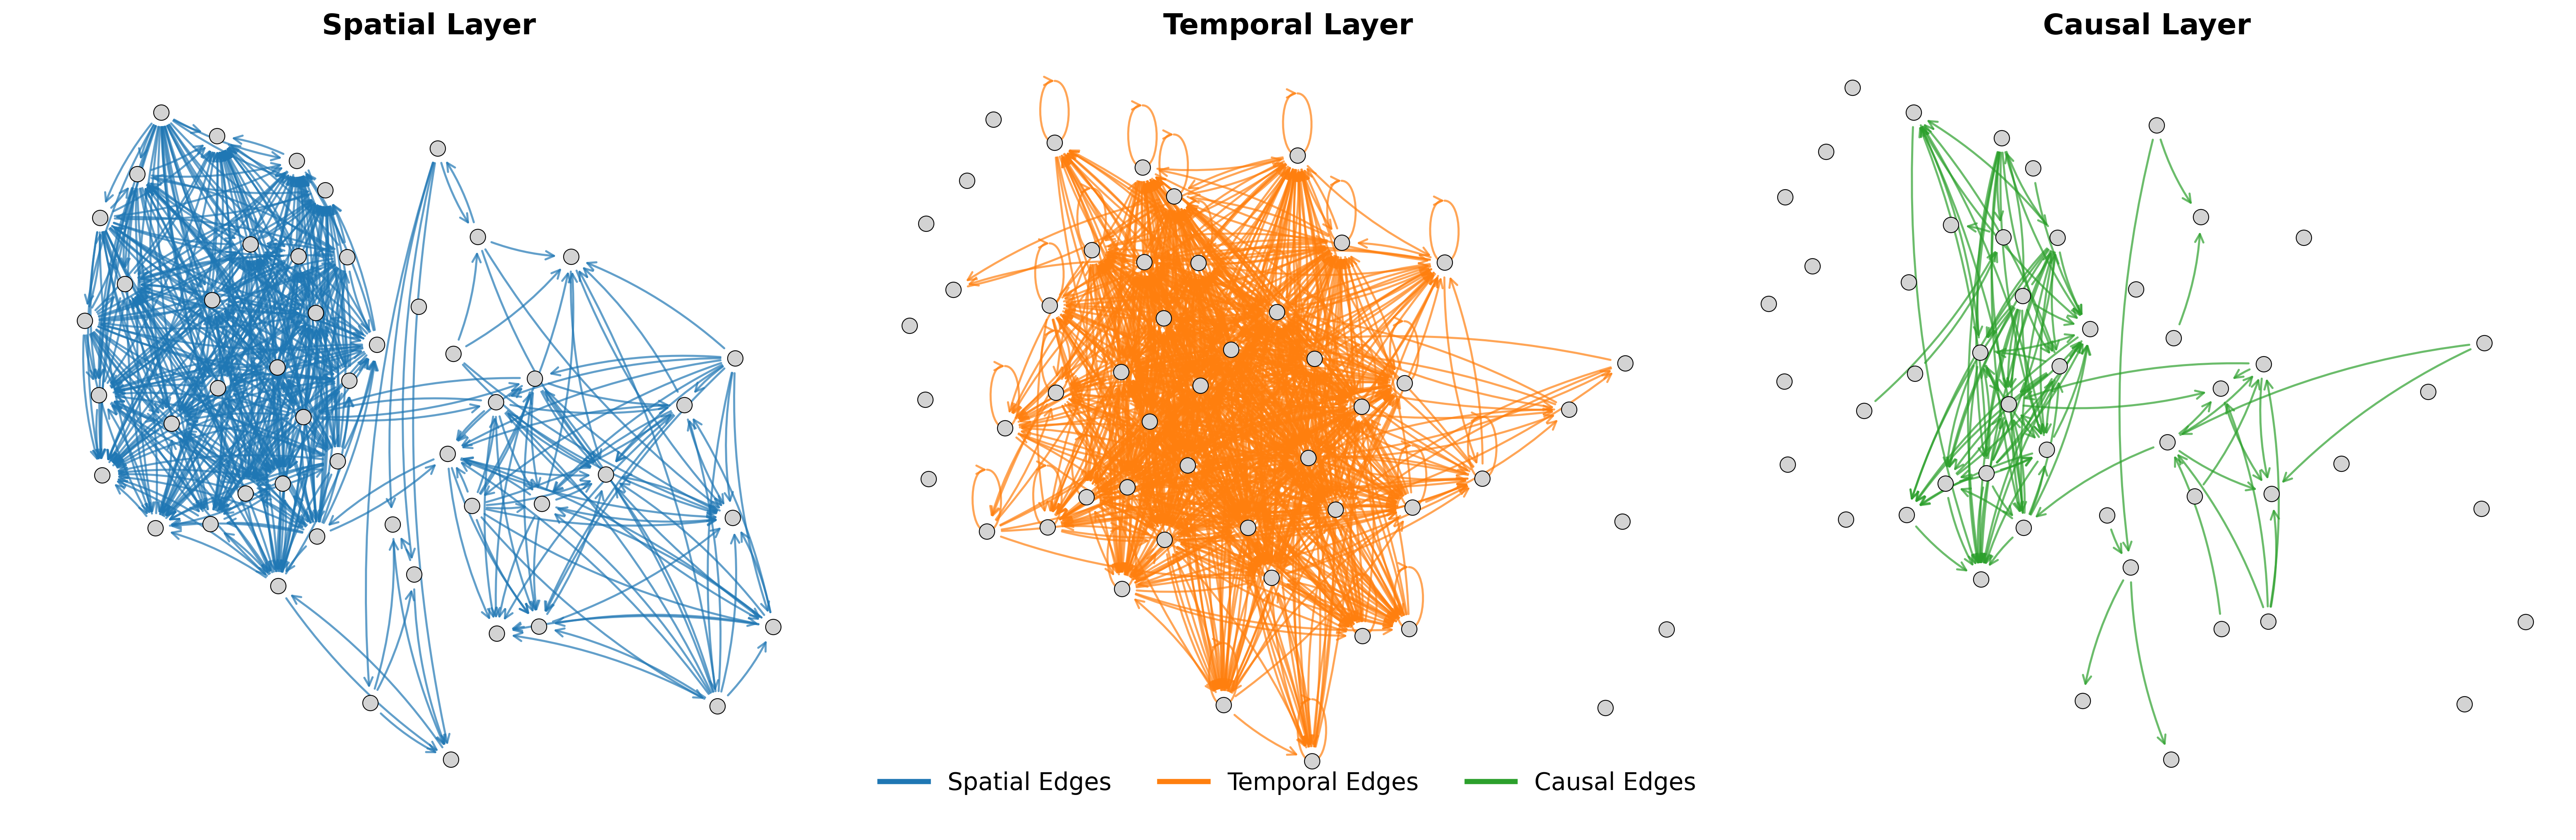

In [17]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import torch

def plot_heterogeneous_graph(data, subset_size=50, layout_seed=42):
    """Plots heterogeneous graph layers with a subset for clarity."""
    plt.rcParams.update({'font.size': 14})  # For research paper readability
    
    # Get all node indices and select subset
    node_indices = list(range(data['substation'].num_nodes))
    if len(node_indices) > subset_size:
        subset_indices = random.sample(node_indices, subset_size)
    else:
        subset_indices = node_indices

    # Create combined graph for consistent layout
    combined_G = nx.Graph()
    combined_G.add_nodes_from(subset_indices)
    edge_types = ['spatial', 'temporal', 'causal']
    colors = {'spatial': '#1f77b4', 'temporal': '#ff7f0e', 'causal': '#2ca02c'}  # Colorblind-friendly
    
    # Add all edges from all types for layout computation
    for edge_type in edge_types:
        edge_index = data['substation', edge_type, 'substation'].edge_index.numpy()
        for i in range(edge_index.shape[1]):
            src, dst = edge_index[0, i], edge_index[1, i]
            if src in subset_indices and dst in subset_indices:
                combined_G.add_edge(src, dst)

    # Compute layout once for consistency
    pos = nx.spring_layout(combined_G, k=0.5, iterations=50, seed=layout_seed)

    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(21, 7), dpi=300)
    plt.subplots_adjust(wspace=0.01)  # Reduce space between subplots
    
    # Plot each edge type in separate subplot
    for idx, edge_type in enumerate(edge_types):
        ax = axes[idx]
        G = nx.DiGraph()
        G.add_nodes_from(subset_indices)
        
        # Add edges of this type
        edge_index = data['substation', edge_type, 'substation'].edge_index.numpy()
        edge_count = 0
        for i in range(edge_index.shape[1]):
            src, dst = edge_index[0, i], edge_index[1, i]
            if src in subset_indices and dst in subset_indices:
                G.add_edge(src, dst)
                edge_count += 1
        
        # Skip plotting if no edges in subset
        if edge_count == 0:
            ax.axis('off')
            continue
        
        # Draw nodes and edges
        nx.draw_networkx_nodes(G, pos, ax=ax, node_color='lightgrey', 
                              node_size=80, linewidths=0.5, edgecolors='black')
        nx.draw_networkx_edges(G, pos, ax=ax, edge_color=colors[edge_type],
                              width=1.2, alpha=0.7, arrows=True, 
                              arrowstyle='->', arrowsize=12, 
                              connectionstyle='arc3,rad=0.1')  # Curved edges
        
        # Add layer label
        ax.set_title(f'{edge_type.capitalize()} Layer', fontweight='bold')
        ax.axis('off')

    # Add common legend
    legend_patches = [plt.Line2D([0], [0], color=color, lw=3, 
                      label=f'{et.capitalize()} Edges') 
                     for et, color in colors.items()]
    fig.legend(handles=legend_patches, loc='upper center', 
               ncol=3, bbox_to_anchor=(0.5, 0.12), frameon=False)
    
    plt.tight_layout()
    plt.savefig('heterogeneous_layers.pdf', bbox_inches='tight')  # Vector format for papers
    plt.show()

# Example usage
hetero_graph = torch.load("Hetro_Final_NW_graph_1.pt")
plot_heterogeneous_graph(hetero_graph, subset_size=50)